In [405]:
import pandas_ta as ta
import pandas as pd
import yfinance as yf
import mplfinance as mpf

In [406]:
df = pd.DataFrame().ta.ticker("TSLA")

c:\Users\Arnas Vaicekauskas\AppData\Local\Programs\Python\Python312\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [407]:
def sell(date, balance, asset_quantity, current_price, fee, df):

    asset_price = (1 - fee) * asset_quantity * current_price

    print(f'Sell {asset_quantity:.2f} stock at {current_price:.2f} per stock (asset_price: {asset_price:.2f}, fee: {fee * asset_quantity * current_price})')

    df.loc[date, 'dbalance'] = asset_price
    balance += asset_price

    df.loc[date, 'dasset_quantity'] = -asset_quantity
    asset_quantity = 0

    df.loc[date, 'dfee'] = fee * asset_quantity * current_price

    return (balance, asset_quantity)
    

def buy(date, balance, asset_quantity, current_price, fee, df):

    asset_buy_quantity = balance // ((1 + fee) * current_price)
    asset_price = (1 + fee) * asset_buy_quantity * current_price

    print(f'Buy {asset_buy_quantity:.2f} stock at {current_price:.2f} per stock (asset price: {asset_price:.2f}, fee: {fee * asset_buy_quantity * current_price})')
    asset_quantity += asset_buy_quantity
    balance -= asset_price

    df.loc[date, 'dbalance'] = -asset_price
    df.loc[date, 'dfee'] = fee * asset_buy_quantity * current_price
    df.loc[date, 'dposition'] = asset_buy_quantity

    return (balance, asset_quantity)
    

In [408]:
def initialize_marker_columns(df):
    # zero everywhere, except where buy action happened
    df['buy_action'] = None
    df.loc[df['dsignal'] > 0, 'buy_action'] = df['sma-short']

    # zero everywhere, except where sell action happened
    df['sell_action'] = None
    df.loc[df['dsignal'] < 0, 'sell_action'] = df['sma-short']

def initialize_stop_loss_take_profit_lines(df):
    df['stop_loss'] = stop_loss
    df['take_profit'] = take_profit

def initialize_smas(df, short, long):
    df['sma-short'] = df['Close'].rolling(window=short_window).mean()
    df['sma-long'] = df['Close'].rolling(window=long_window).mean()

    df['signal'] = 0
    df.loc[df['sma-short'] > df['sma-long'], 'signal'] = 1
    df.loc[df['sma-short'] < df['sma-long'], 'signal'] = -1

    df['dsignal'] = df['signal'].diff()

def run_trend_following_strategy(df, fee, short, long, stop_loss, take_profit, initial_investment, start_date, stop_date):
    
    # not necessary, but helpful for visualization
    initialize_stop_loss_take_profit_lines(df)
    initialize_smas(df, short, long)
    initialize_marker_columns(df)

    # filter trading time frame to specified window
    # trading sim will happen from start_date to end_date
    df = df[df.index >= start_date]
    df = df[df.index <= end_date]

    df['dbalance'] = 0.0
    df['dfee'] = 0.0
    df['dasset_quantity'] = 0.0
    
    balance = initial_investment
    asset_quantity = 0

    for date, signal in zip(df.index, df['dsignal']):

        current_price = df['Close'][date]

        # calculate profit at time t
        if(current_price <= stop_loss or current_price >= take_profit):
    
            # sell & stop trading
            print('[stop loss]') if current_price <= stop_loss else print('[take profit]')
            balance, asset_quantity = sell(date, balance, asset_quantity, current_price, fee, df)
            break

        if(signal == 0):
            continue

        print(f'date: {date}')
        print(f'[pos: {asset_quantity}, bal: {balance}]')

        if(signal > 0): # buy
            balance, asset_quantity = buy(date, balance, asset_quantity, current_price, fee, df)
        
        else: # sell
            balance, asset_quantity = sell(date, balance, asset_quantity, current_price, fee, df)

    # after simulation sell everything for last known price
    print(f'[qnt: {asset_quantity}, bal: {balance}]')
    balance, asset_quantity = sell(date, balance, asset_quantity, df['Close'][-1], fee, df)
    print(f'[qnt: {asset_quantity}, bal: {balance}]')
    print(f'profit: {balance - initial_investment:.2f}')
    print(f'min price: {df['Close'].min():.2f}')
    print(f'max price: {df['Close'].max():.2f}')

In [409]:
fee = 0.02
short_window, long_window = 10, 20
initial_investment = 1000
stop_loss, take_profit = 100, 300
start_date, end_date = '2023-01-01', '2023-12-31'
run_trend_following_strategy(df, fee, short_window, long_window, stop_loss, take_profit, initial_investment, start_date, end_date)

date: 2023-01-19 00:00:00-05:00
[pos: 0, bal: 1000]
Buy 7.00 stock at 127.17 per stock (asset price: 907.99, fee: 17.803799743652345)
date: 2023-03-06 00:00:00-05:00
[pos: 7.0, bal: 92.00621307373035]
Sell 7.00 stock at 193.81 per stock (asset_price: 1329.54, fee: 27.13339965820313)
date: 2023-03-28 00:00:00-04:00
[pos: 0, bal: 1421.5427963256834]
Buy 7.00 stock at 189.19 per stock (asset price: 1350.82, fee: 26.486600341796876)
date: 2023-04-14 00:00:00-04:00
[pos: 7.0, bal: 70.72617889404273]
Sell 7.00 stock at 185.00 per stock (asset_price: 1269.10, fee: 25.900000000000002)
date: 2023-05-15 00:00:00-04:00
[pos: 0, bal: 1339.8261788940426]
Buy 7.00 stock at 166.35 per stock (asset price: 1187.74, fee: 23.28900085449219)
date: 2023-07-28 00:00:00-04:00
[pos: 7.0, bal: 152.08713531494095]
Sell 7.00 stock at 266.44 per stock (asset_price: 1827.78, fee: 37.30160034179688)
date: 2023-09-01 00:00:00-04:00
[pos: 0, bal: 1979.8655520629877]
Buy 7.00 stock at 245.01 per stock (asset price: 17

C:\Users\Arnas Vaicekauskas\AppData\Local\Temp\ipykernel_24188\3708775429.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  balance, asset_quantity = sell(date, balance, asset_quantity, df['Close'][-1], fee, df)


c:\Users\Arnas Vaicekauskas\AppData\Local\Programs\Python\Python312\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


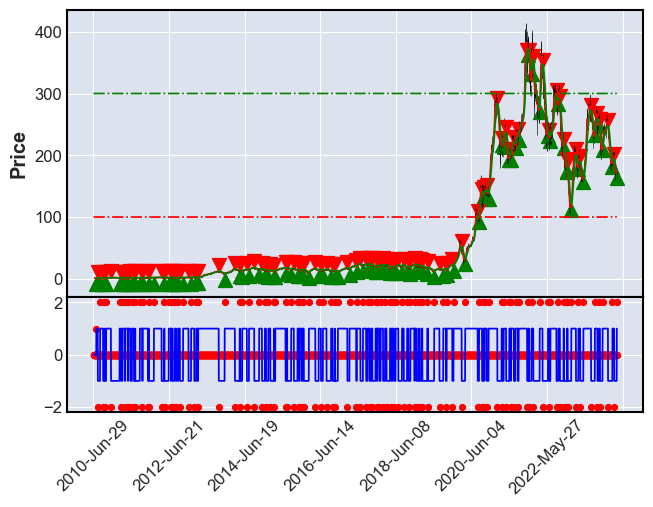

In [410]:
marker_offset = 10

apds = [
    mpf.make_addplot(df['stop_loss'], color='r', linestyle='-.'),
    mpf.make_addplot(df['take_profit'], color='g', linestyle='-.'),
    mpf.make_addplot(df['buy_action'] - marker_offset, type='scatter', panel=0, secondary_y=False, markersize=100, marker='^', color = 'green'),
    mpf.make_addplot(df['sell_action'] + marker_offset, type='scatter', panel=0, secondary_y=False, markersize=100, marker='v', color = 'red'),
    mpf.make_addplot(df['dsignal'], type='scatter', panel=1, color='r', secondary_y=False),
    mpf.make_addplot(df['sma-short'], panel=0, color='r', secondary_y=False),
    mpf.make_addplot(df['sma-long'], panel=0, color='g', secondary_y=False),
    mpf.make_addplot(df['signal'], panel=1, color='b', secondary_y=False)
]

mpf.plot(df, type='candle', addplot=apds, volume=False)

In [411]:

df['qnt'] = df['dasset_quantity'].cumsum()
df['fee'] = df['dfee'].cumsum()
df['bal'] = df['dbalance'].cumsum()

# adjusted values -1 to 1 -> 0 to 1
# this can be used as a mask
adjusted_sig = (df['signal'] + 1) / 2

# worth of position at time t
# 0 if not bought it
# intervals begin with buy-in price and evolve until buy-out
df['masked_close'] = adjusted_sig * df['Close'] * df['qnt']

# Change of position value over time (no change when not bought-in)
dclose = df['Close'].diff()
df['dprofit'] = adjusted_sig * dclose * df['qnt'] - df['dfee']

# price of stocks I bought at time t
buy_signals = df['dsignal'].apply(lambda x: max(x, 0))
df['buy_price'] = buy_signals * df['Close'] * df['qnt']

# price of stocks I sold at time t
sell_signals = df['dsignal'].apply(lambda x: min(x, 0))
df['sell_price'] = sell_signals * df['Close'] * df['qnt']

# buy and sell price are offset

# intervals that have value of buy-in cost
df['buy-in_intervals'] = 0

in_interval = False
interval_value = 0

for date, row in df.iterrows():
    
    ds = row['dsignal']

    # we're already in the interval
    if in_interval:
        # we exited the interval
        if ds < 0:
            in_interval = False
        # set values
        else:
            df.loc[date, 'buy-in_intervals'] = interval_value
    # we're not in an interval
    else:
        # we entered an interval
        if ds > 0:
            in_interval = True
            interval_value = df['qnt'][date] * df['Close'][date]
            df.loc[date, 'buy-in_intervals'] = interval_value

df['profit'] = df['dprofit'].cumsum()

apds = [
    mpf.make_addplot(df['fee'], panel=3, color='r'),
    mpf.make_addplot(df['bal'], panel=1, color='g'),
    mpf.make_addplot(df['qnt'], panel=2, color='b'),
    mpf.make_addplot(df['buy-in_intervals'], panel=4, color='c'),
    mpf.make_addplot(df['dprofit'], panel=5, color='r'),
    mpf.make_addplot(df['profit'], panel=6, color='r'),
]

mpf.plot(df, type='candle', addplot=apds, volume=False)

KeyError: 'dasset_quantity'